# Compare results across hyperparameters
Collect performance information like F1 scores for a given model architecture while varying the hyperparameters in the objective function that weight the weak and self-supervised terms; plot performance several different ways in a heatmap format

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
import os
import pandas as pd
import pickle
import seaborn as sns

from daart.data import DataGenerator
from daart.eval import get_precision_recall, run_lengths
from daart.io import get_expt_dir
from daart.transforms import ZScore
from daart.data import compute_sequence_pad

from daart_utils.data import DataHandler
from daart_utils.models import compute_model_predictions
from daart_utils.paths import data_path, results_path
from daart_utils.plotting import plot_heatmaps

In [2]:
# save predicted states from models
save_states = True
# overwrite predicted states from models
overwrite_states = False
# compute state statistics like median bout duration and behavior ratios
compute_state_stats = False

dataset = 'fly'
input_type = 'markers'  # 'markers' | 'features-simba' | etc.
variational = True # bool value

if dataset == 'fly':
    from daart_utils.session_ids.fly import SESS_IDS_TRAIN_5, SESS_IDS_TEST
    from daart_utils.session_ids.fly import label_names
elif dataset == 'ibl':
    from daart_utils.session_ids.ibl import SESS_IDS_TRAIN_5, SESS_IDS_TEST
    from daart_utils.session_ids.ibl import label_names
    
# train datasets
sess_ids = SESS_IDS_TRAIN_5[0]
# test datasets
sess_ids_test = SESS_IDS_TEST

expt_dir = get_expt_dir(os.path.join(results_path, dataset), sess_ids)
print(expt_dir)

# ATTN: need to set these params to match models that were fit
lambda_weak = [0, 1, 5]
lambda_strong = 1
lambda_pred = [0, 1, 5]

model_type = 'dtcn'
device = 'cuda'
# changed batch size to be consistent with train config
batch_size = 2
tt_expt_dir = 'test'

# added the fields input_type and backbone
hparams = {
    'input_type': input_type,
    'rng_seed_train': 0,
    'rng_seed_model': 0,
    'trial_splits': '9;1;0;0',
    'train_frac': 1,
    'batch_size': batch_size,
    'model_type': model_type,
    'learning_rate': 1e-4,
    'n_hid_layers': 2,
    'n_hid_units': 32,
    'n_lags': 4,
    'l2_reg': 0,
    'lambda_strong': lambda_strong,
    'bidirectional': True,
    'device': device,
    'dropout': 0.1,
    'activation': 'lrelu',
    'sequence_length': 500,
    'input_type': input_type,
    'backbone': 'dtcn',
    'variational': variational
}

# replaced batch_pad with sequence_pad
hparams['sequence_pad'] = compute_sequence_pad(hparams)
hparams['tt_expt_dir'] = os.path.join(expt_dir, model_type, tt_expt_dir)
model_types = [model_type]  # legacy, need to clean up

metrics_df = []

print('len test sess', len(sess_ids_test))
for sess_id_test in sess_ids_test:
    
    # initialize data handler; point to correct base path
    handler = DataHandler(sess_id_test, base_path=os.path.join(data_path, dataset))
    if input_type == 'markers':
        markers_file = handler.get_marker_filepath()
    else:
        markers_file = handler.get_feature_filepath(dirname=input_type)

    # define data generator signals
    signals = ['markers']
    transforms = [ZScore()]
    paths = [markers_file]

    # build data generator
    data_gen_test = DataGenerator(
        [sess_id_test], [signals], [transforms], [paths], device=device, 
        batch_size=batch_size, trial_splits=hparams['trial_splits'], 
        #batch_pad=hparams['batch_pad'])
        sequence_pad=hparams['sequence_pad'])
    print('----------------------------')
    print(data_gen_test)
    print('----------------------------')
    print('\n')

    # load hand labels
    handler.load_hand_labels()
    states = np.argmax(handler.hand_labels.vals, axis=1)
    # removed cutoff
    #cutoff = int(np.floor(states.shape[0] / batch_size)) * batch_size
    #states = states[:cutoff]

    # load heuristic labels
    handler.load_heuristic_labels()
    states_h = np.argmax(handler.heuristic_labels.vals, axis=1)
    # removed cutoff
    states_heuristic = states_h

    # -----------------------------------------
    # collect results
    # -----------------------------------------        
    for lw in lambda_weak:
        for lp in lambda_pred:
            hparams['lambda_weak'] = lw
            hparams['lambda_pred'] = lp
            
            # f1, precision, accuracy
            scores = {m: None for m in model_types}
            # ratio of time spent in each state
            ratios = {m: None for m in model_types}
            # median bout length for each state
            bout_lens = {m: None for m in model_types}

            # load/compute predictions
            try:
                predictions = compute_model_predictions(
                    hparams, data_gen_test, save_states=save_states, 
                    overwrite_states=overwrite_states)
            except (FileNotFoundError, NotADirectoryError):
                print('no data found')
                continue

            # compute precision and recall for each behavior type (model)
            scores[model_type] = get_precision_recall(
                states[:len(predictions)], predictions, background=0, n_classes=len(label_names) - 1)

            if compute_state_stats:
                ratios[model_type] = np.bincount(predictions) / len(predictions)
                bouts = run_lengths(predictions)
                bout_lens[model_type] = [np.median(a) for _, a in bouts.items()]
            else:
                ratios[model_type] = [None] * (len(label_names) + 1)
                bout_lens[model_type] = [None] * (len(label_names) + 1)

            # compute precision and recall for each behavior type (heuristic)
            scores['heuristic'] = get_precision_recall(
                states, states_heuristic, background=0, n_classes=len(label_names) - 1)

            # store
            for l, label_name in enumerate(label_names[1:]):
                df_dict = {
                    'sess_id': sess_id_test,
                    'label': label_name,
                    'lambda_weak': lw,
                    'lambda_pred': lp,
                    'precision_heur': scores['heuristic']['precision'][l],
                    'recall_heur': scores['heuristic']['recall'][l],
                    'f1_heur': scores['heuristic']['f1'][l],
                }
                for model_type in model_types:
                    model_name = 'mlp' if model_type == 'temporal-mlp' else model_type
                    df_dict['precision_%s' % model_name] = scores[model_type]['precision'][l]
                    df_dict['recall_%s' % model_name] = scores[model_type]['recall'][l]
                    df_dict['f1_%s' % model_name] = scores[model_type]['f1'][l]
                    df_dict['ratio_%s' % model_name] = ratios[model_type][l + 1]
                    df_dict['bout_len_%s' % model_name] = bout_lens[model_type][l + 1]
                metrics_df.append(pd.DataFrame(df_dict, index=[0]))

metrics_df = pd.concat(metrics_df)

/home/bsb2144/daart/daart_utils/results/fly/multi-0
len test sess 5
----------------------------
Generator contains 1 SingleDataset objects:
2019_06_26_fly2
    signals: ['markers']
    transforms: OrderedDict([('markers', ZScore())])
    paths: OrderedDict([('markers', '/home/bsb2144/daart/daart_utils/data/fly/markers/2019_06_26_fly2_labeled.h5')])

----------------------------


----------------------------
Generator contains 1 SingleDataset objects:
2019_08_14_fly1
    signals: ['markers']
    transforms: OrderedDict([('markers', ZScore())])
    paths: OrderedDict([('markers', '/home/bsb2144/daart/daart_utils/data/fly/markers/2019_08_14_fly1_labeled.h5')])

----------------------------


----------------------------
Generator contains 1 SingleDataset objects:
2019_08_20_fly3
    signals: ['markers']
    transforms: OrderedDict([('markers', ZScore())])
    paths: OrderedDict([('markers', '/home/bsb2144/daart/daart_utils/data/fly/markers/2019_08_20_fly3_labeled.h5')])

---------------

### plot results: heat plots for single model

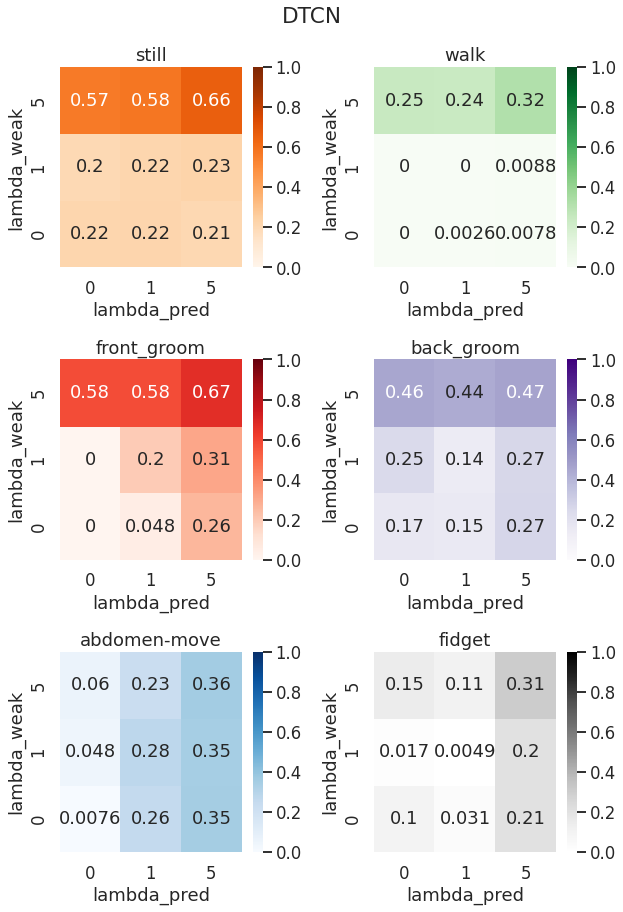

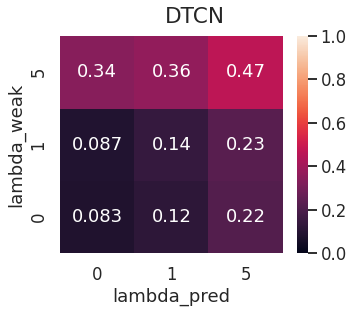

In [3]:
sns.set_context('talk')
sns.set_style('white')

metric = 'f1_dtcn'

n_rows = 2
n_cols = 2

# 1: by dataset/label
# 2: by label, avg over datasets
# 3: avg over dataset/label
plot_types = [2, 3]

for plot_type in plot_types:
    annot = True #True if plot_type == 3 else False
    plot_heatmaps(
        df=metrics_df, metric=metric, sess_ids=sess_ids_test, 
        # changed range to 0.0 - 1.0
        title=metric.split('_')[-1].upper(), kind=plot_type, vmin=0.0, vmax=1,
        annot=annot,
        # changed colors so that points are low -> high color with low -> high probability 
        cmaps=['Oranges', 'Greens', 'Reds', 'Purples', 'Blues', 'Greys'],
        save_file=None)
